### Primary spectral analysis for CCS using WRF outputs

##### Uses Xrft
##### Divides two regions for better analysis

In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter as gauss
from pyspec import spectrum as spec
from matplotlib.colors import LogNorm
import warnings
import scipy.integrate as integ
warnings.filterwarnings("ignore")

In [31]:
chunks_new={'time_counter':20}
path='/data/pacific/lrenault/SASI/FULL/WRF/'
listm=glob(path+'*DAY.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[-9:],chunks=chunks_new,data_vars='minimal')


path='/data/pacific/lrenault/SASI/SMTH/WRF/'
listt=glob(path+'*DAY.nc');listt.sort()
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt,chunks=chunks_new,data_vars='minimal')

In [42]:
plt.rcParams['font.size']=15
plt.rcParams['font.sans-serif']='Arial'
plt.rcParams['font.weight']='bold'

##### Defining the dx and dy in meters (approximately)

In [24]:
dxx=2
dyy=2

# dxx=0.014*111
# dyy=0.014*111

## SST - Test

In [6]:
tf=varf.SST[:,30:-30,30:200] 
tt=vart.SST[:,30:-30,30:200]

exspec=xrft.isotropic_powerspectrum(tf[0].drop(['nav_lat','nav_lon']),detrend='linear', window=True)

Tf=np.zeros([tf.shape[0],exspec.shape[0]])*np.nan;
Tt=np.zeros([tt.shape[0],exspec.shape[0]])*np.nan;

for ixx in range(tf.shape[0]):
    tpf=xrft.isotropic_power_spectrum(tf[ixx].drop(['nav_lon','nav_lat']),detrend='linear', window=True)
    tpt=xrft.isotropic_power_spectrum(tt[ixx].drop(['nav_lon','nav_lat']),detrend='linear', window=True)

    Tf[ixx,:]=(tpf.to_numpy())
    Tt[ixx,:]=(tpt.to_numpy())

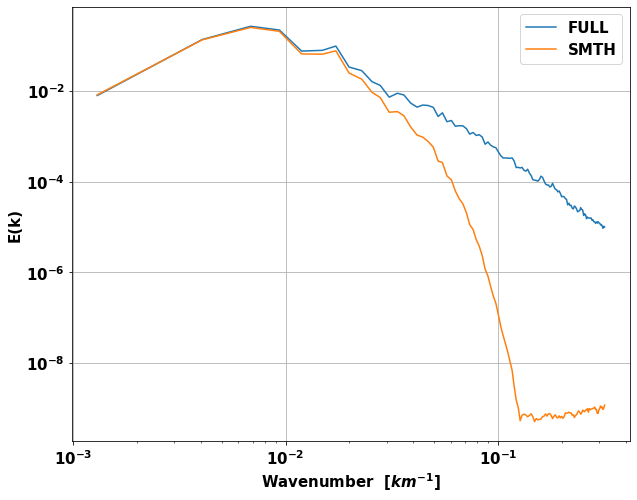

In [13]:
#Compare with Lionel's Figure
AAF=xrft.isotropic_power_spectrum(tf[0].drop(['nav_lon','nav_lat']),nfactor=1,truncate='True',detrend='linear', window=True)
AAT=xrft.isotropic_power_spectrum(tt[0].drop(['nav_lon','nav_lat']),nfactor=1,truncate='True',detrend='linear', window=True)
5
plt.figure(figsize=(10,8))
# plt.plot([1/55,1/55],[AAT.min(),AAT.max()],'k--')
# plt.plot([1/100,1/100],[AAT.min(),AAT.max()],'k--')


# plt.title('SST')
plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'E(k)',fontweight='bold')



plt.plot((AAF.freq_r/dxx),(AAF),label='FULL')
plt.plot((AAT.freq_r/dxx),(AAT),label='SMTH')
plt.xscale('log')
plt.yscale('log')
plt.legend()
# plt.ylim(-10,0)
# plt.xlim(-2,0)
plt.grid()

plt.savefig('/homes/metogra/iufarias/Documents/figures/slide_aid/sst_spec.png')



## Tests

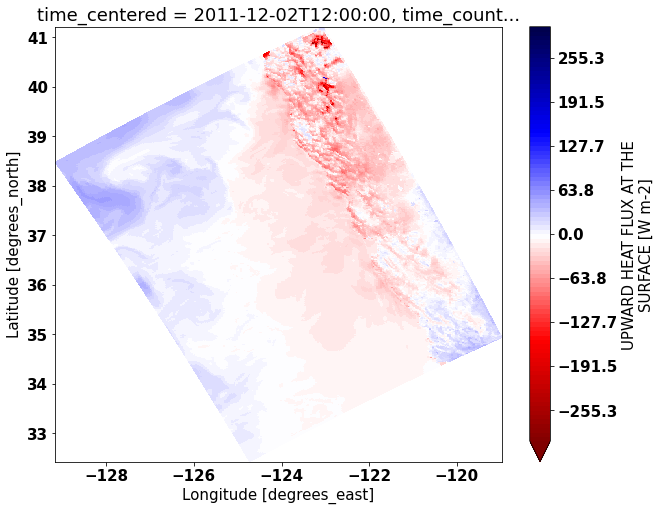

In [24]:
varf.time_counter[30]
plt.figure(figsize=(10,8))


varf.HFX[31,:,:].plot(x="nav_lon",y="nav_lat",cmap='seismic_r',levels=np.linspace(-300,300,95))

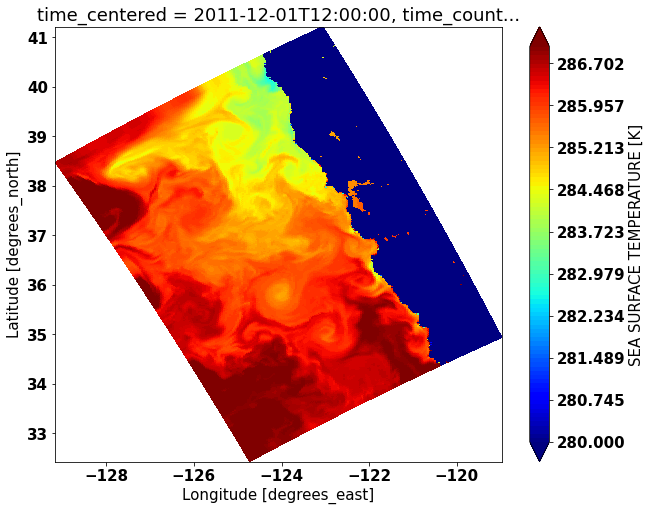

In [26]:
plt.figure(figsize=(10,8))
varf.SST[30,:,:].plot(x="nav_lon",y="nav_lat",cmap='jet',levels=np.linspace(280,287,95))

## Heatflux

In [5]:

hf=varf.HFX[:,30:-30,30:200] 
ht=vart.HFX[:,30:-30,30:200]

exspec=xrft.isotropic_powerspectrum(hf[0].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)

Hf=np.zeros([hf.shape[0],exspec.shape[0]])*np.nan;
Ht=np.zeros([ht.shape[0],exspec.shape[0]])*np.nan;

for ixx in range(hf.shape[0]):
    hpf=xrft.isotropic_power_spectrum(hf[ixx].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)
    hpt=xrft.isotropic_power_spectrum(ht[ixx].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)

    Hf[ixx,:]=(hpf.to_numpy())
    Ht[ixx,:]=(hpt.to_numpy())

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


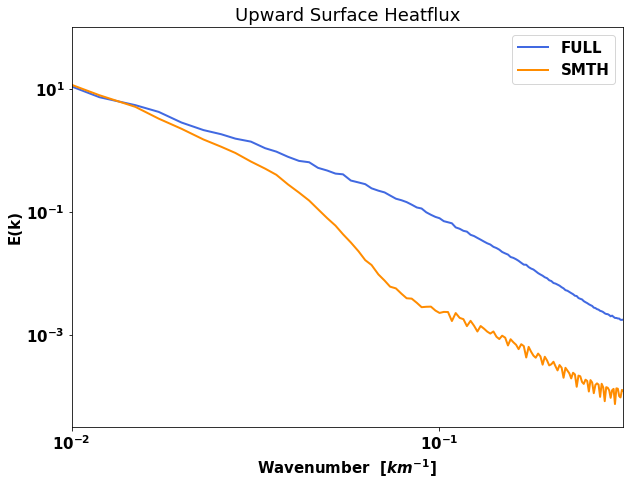

In [8]:


plt.figure(figsize=(9,7))


plt.plot(np.log10(exspec.freq_r/dxx),
        np.log10(np.nanmean(Hf,axis=0)),label='FULL',linewidth=2,color='royalblue')


plt.plot(np.log10(exspec.freq_r/dxx),
        np.log10(np.nanmean(Ht,axis=0)),label='SMTH',linewidth=2,color='darkorange')

# plt.plot(np.log10(k2),np.log10(E2),'k--')




plt.legend()

# plt.grid()
# plt.title('Full Period {0}'.format(varr))
# plt.xlim(-5,-3)
plt.xticks(np.array([-2,-1]),[r'10$^{-2}$',r'10$^{-1}$'])
plt.yticks(np.array([-3,-1,1,3,6]),[r'10$^{-3}$',r'10$^{-1}$',r'10$^{1}$',r'10$^{3}$',r'10$^{6}$'])


plt.title('Upward Surface Heatflux')
plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'E(k)',fontweight='bold')

plt.xlim(-2,-0.5)
plt.ylim(-4.5,2)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/Scripts/figures/Total_avg_Heatflux.png')



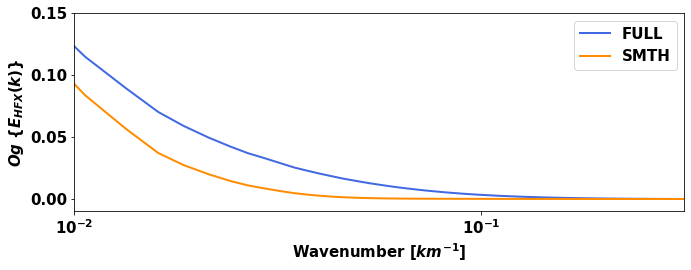

In [26]:

HHf=np.nanmean(Hf,axis=0)
HHt=np.nanmean(Ht,axis=0)

Kk=np.array(exspec.freq_r/dxx)
Kx=(Kk[:-1]+Kk[1:])/2
dK=np.diff(Kk)[0]


HAf=integ.cumtrapz(y=HHf[::-1],x=Kk[::-1]);
HAt=integ.cumtrapz(y=HHt[::-1],x=Kk[::-1]);

HAf=-HAf[::-1]
HAt=-HAt[::-1]

fig,ax = plt.subplots(figsize=(10,4))
ax.plot((np.log10(Kx)),HAf,label='FULL',linewidth=2,color='royalblue')
ax.plot((np.log10(Kx)),HAt,label='SMTH',linewidth=2,color='darkorange')
ax.set_xticks(np.array([-2,-1]))
ax.set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])

ax.set_xlabel(r'Wavenumber $ [km^{-1}]$',fontsize=15,fontweight='bold')
ax.set_ylabel(r'$Og$ {$E_{HFX}(k)$}',color="k",fontsize=15,fontweight='bold')
ax.set_xlim(-2,-0.5)
ax.set_ylim(-0.01,0.15)



ax.legend()

# ax2=ax.twinx()
# ax2.plot(np.log10(Kx),(1-(HAf)/(HAt))*100,alpha=0.5,linestyle='dashed',color='cadetblue')
# ax2.set_ylabel(r' Ratio ($1 - \frac{FULL}{SMTH}$) [$\%$]',fontsize=15,color='cadetblue')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/Scripts/figures/Ogive_total_avg_HFX.png')



In [9]:
import datetime

t_ind=pd.DatetimeIndex(hf.time_centered.compute())
mon_ind=pd.DatetimeIndex(hf.time_centered.compute()).month
mes=np.array([11,12,1,2,3,4,5,6,7])
mes_str=['Nov/11','Dec/11','Jan/12','Feb/12','Mar/12','Apr/12','May/12','Jun/12','Jul/12']

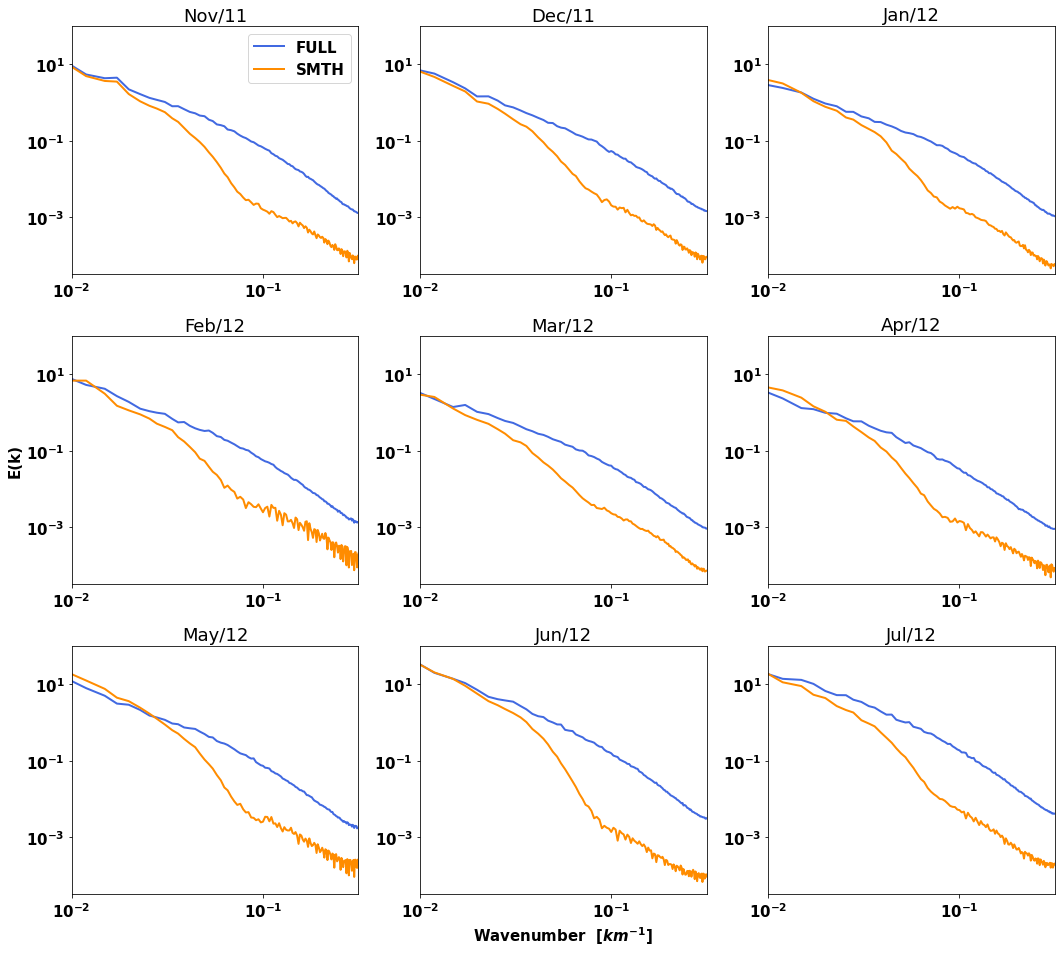

In [35]:
fig, axs = plt.subplots(3,3, figsize=(15, 13.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 1, wspace=.01)

axs = axs.ravel()

for ipp in range(len(mes)):

    axs[ipp].plot(np.log10(exspec.freq_r/dxx),np.log10(np.nanmean(Hf[mon_ind==mes[ipp],:],axis=0)),label='FULL',linewidth=2,color='royalblue')
    axs[ipp].plot(np.log10(exspec.freq_r/dxx),np.log10(np.nanmean(Ht[mon_ind==mes[ipp],:],axis=0)),label='SMTH',linewidth=2,color='darkorange')
    # axs[ipp].grid()
    axs[ipp].set_title(mes_str[ipp])
    axs[ipp].set_xticks(np.array([-2,-1]))
    axs[ipp].set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
    axs[ipp].set_yticks(np.array([-3,-1,1,3,6]))
    axs[ipp].set_yticklabels([r'10$^{-3}$',r'10$^{-1}$',r'10$^{1}$',r'10$^{3}$',r'10$^{6}$'])
    axs[3].set_ylabel(r'E(k)',fontweight='bold')
    axs[7].set_xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
    axs[0].legend()
    axs[ipp].set_xlim(-2,-0.5)
    axs[ipp].set_ylim(-4.5,2)
    
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/Scripts/figures/monthly_HF.png')



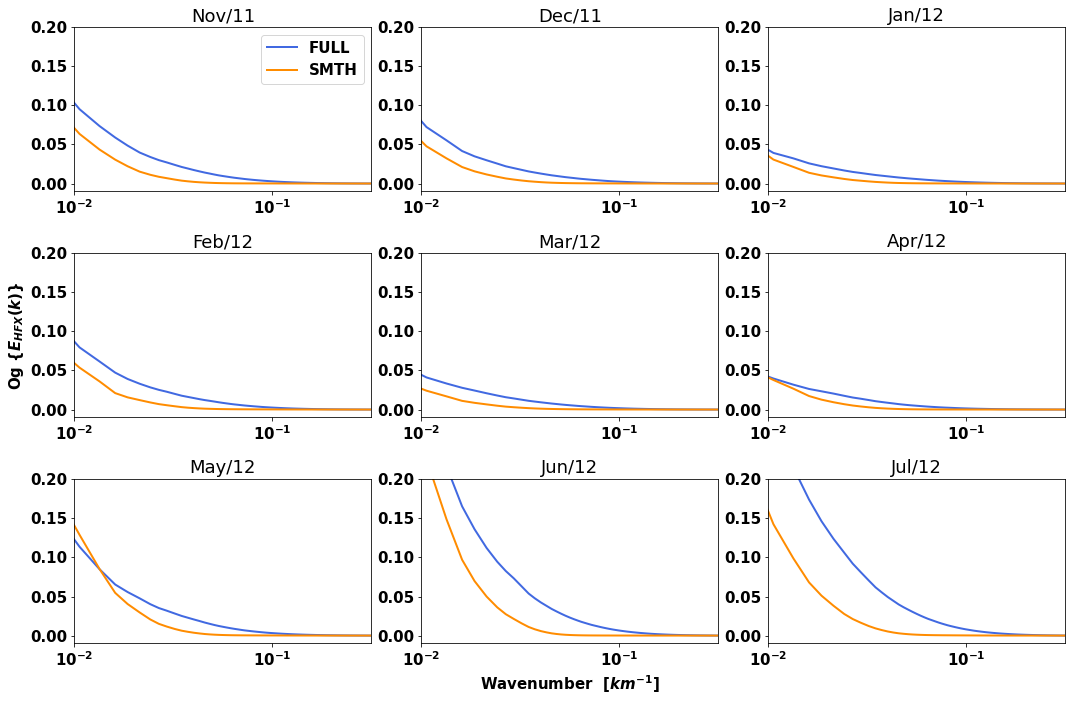

In [27]:
exspec=xrft.isotropic_powerspectrum(hf[0].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)



fig, axs = plt.subplots(3,3, figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 2, wspace=.01)

axs = axs.ravel()


for ipp in range(len(mes)):

    Hmf=np.nanmean(Hf[mon_ind==mes[ipp],:],axis=0)
    Hmt=np.nanmean(Ht[mon_ind==mes[ipp],:],axis=0)

    Kk=np.array(exspec.freq_r/dxx)
    Kx=(Kk[:-1]+Kk[1:])/2
    dK=np.diff(Kk)[0]
    
    HHmf=integ.cumtrapz(y=Hmf[::-1],x=Kk[::-1]);
    HHmt=integ.cumtrapz(y=Hmt[::-1],x=Kk[::-1]);
    HHmf=-HHmf[::-1]
    HHmt=-HHmt[::-1]

    

    
    axs[ipp].plot(np.log10(Kx),HHmf,label='FULL',linewidth=2,color='royalblue')
    axs[ipp].plot(np.log10(Kx),HHmt,label='SMTH',linewidth=2,color='darkorange')

    axs[ipp].set_title(mes_str[ipp])

    axs[7].set_xlabel(r'Wavenumber  [$km^{-1}]$',fontsize=15,fontweight='bold')
    axs[3].set_ylabel(r'Og {$E_{HFX}(k)$}',color="k",fontsize=15,fontweight='bold')
    axs[0].legend()
    axs[ipp].set_xlim(-2,-0.5)
    axs[ipp].set_ylim(-0.01,0.2)


    axs[ipp].set_xticks(np.array([-2,-1]))
    axs[ipp].set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
    

    # ax2=axs[ipp].twinx()
    # ax2.plot(np.log10(Kx),(1-(KEf)/(KEt))*100,alpha=0.5,linestyle='dashed',color='cadetblue')
    # if ipp in [2,5,8]:
    #     ax2.set_ylabel(r' Ratio ($1 - \frac{FULL}{SMTH}$) [$\%$]',fontsize=15,color='cadetblue')
    # ax2.set_ylim(-20,20)
plt.tight_layout()

plt.savefig('/homes/metogra/iufarias/Documents/Scripts/figures/Ogive_monthly_HFX.png')



## KE Spectral Analysis (Whole Region)
#### Area of study cropped in attempt to exclude the effect of model's "sponge" and coastline

In [115]:
uf=varf.UOCE[:,30:-30,30:200].compute()
vf=varf.VOCE[:,30:-30,30:200].compute()

ut=vart.UOCE[:,30:-30,30:200].compute()
vt=vart.VOCE[:,30:-30,30:200].compute()

### Creating daily spectra array
##### Using an example to creating a simple array for all the daily spectra
##### The KE spectrum is computed by adding the U and V spectra then diving by 2

In [37]:

exspec=xrft.isotropic_powerspectrum(uf[0].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)

Ekef=np.zeros([uf.shape[0],exspec.shape[0]])*np.nan;
Eket=np.zeros([ut.shape[0],exspec.shape[0]])*np.nan;

for ixx in range(hf.shape[0]):
    uspf=xrft.isotropic_powerspectrum(uf[ixx].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)
    vspf=xrft.isotropic_powerspectrum(vf[ixx].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)
    uspt=xrft.isotropic_powerspectrum(ut[ixx].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)
    vspt=xrft.isotropic_powerspectrum(vt[ixx].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)


    Ekef[ixx,:]=(uspf.to_numpy()+ vspf.to_numpy())/2
    Eket[ixx,:]=(uspt.to_numpy() + vspt.to_numpy())/2

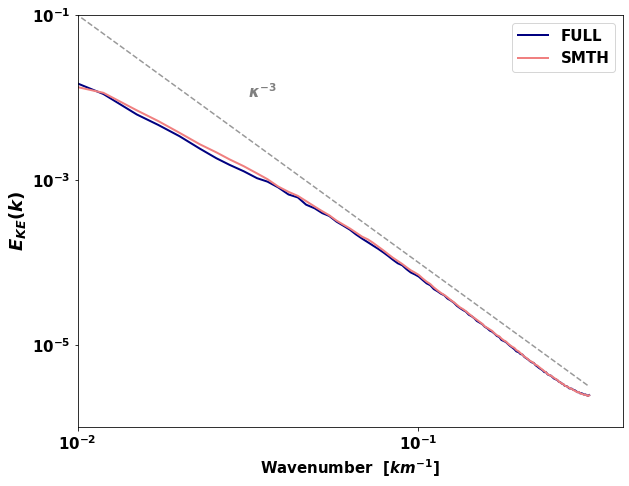

In [70]:
# k2 = np.array([exspec.freq_r[0],exspec.freq_r[-1]])/dxx
# E2 = 1/k2**2/(10**6.8)
k3 = np.array([exspec.freq_r[0],exspec.freq_r[-1]])/dxx
E3 = 1/k3**3/(10**7.)


plt.figure(figsize=(9,7))
plt.plot(np.log10(exspec.freq_r/dxx),
        np.log10(np.nanmean(Ekef,axis=0)),label='FULL',linewidth=2,color='navy')


plt.plot(np.log10(exspec.freq_r/dxx),
        np.log10(np.nanmean(Eket,axis=0)),label='SMTH',linewidth=2,color='lightcoral')

# plt.plot(np.log10(k2),np.log10(E2),'k--',label=r'$\kappa^{-2}$')
plt.plot(np.log10(k3),np.log10(E3),'k--',alpha=0.4)
plt.text(-1.5,-2,r'$\kappa^{-3}$',weight='normal',alpha=0.5)




plt.legend()

# plt.grid()
# plt.title('Full Period {0}'.format(varr))
# plt.xlim(-5,-3)
plt.xticks(np.array([-2,-1]),[r'10$^{-2}$',r'10$^{-1}$'])
plt.yticks(np.array([-5,-3,-1,1,3]),[r'10$^{-5}$',r'10$^{-3}$',r'10$^{-1}$',r'10$^{1}$',r'10$^{3}$'])


#plt.title(np.datetime_as_string(varf.time_counter[xday].data)[:10])
plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'$E_{KE}(k) \,\,$',fontweight='bold',fontsize=18)
plt.xlim(-2,-0.4)
plt.ylim(-6,-1)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/Scripts/figures/Total_avg_KE.png')

In [55]:
'Ogive graph - Backwards'

'Ogive graph - Backwards'

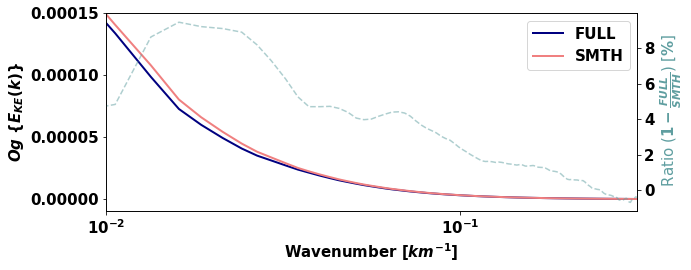

In [69]:

Kf=np.nanmean(Ekef,axis=0)
Kt=np.nanmean(Eket,axis=0)

Kk=np.array(exspec.freq_r/dxx)
Kx=(Kk[:-1]+Kk[1:])/2
dK=np.diff(Kk)[0]


KAf=integ.cumtrapz(y=Kf[::-1],x=Kk[::-1]);
KAt=integ.cumtrapz(y=Kt[::-1],x=Kk[::-1]);

KAf=-KAf[::-1]
KAt=-KAt[::-1]

fig,ax = plt.subplots(figsize=(10,4))
ax.plot((np.log10(Kx)),KAf,label='FULL',linewidth=2,color='navy')
ax.plot((np.log10(Kx)),KAt,label='SMTH',linewidth=2,color='lightcoral')
ax.set_xticks(np.array([-2,-1]))
ax.set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])

ax.set_xlabel(r'Wavenumber $ [km^{-1}]$',fontsize=15,fontweight='bold')
ax.set_ylabel(r'$Og$ {$E_{KE}(k)$}',color="k",fontsize=15,fontweight='bold')
ax.set_xlim(-2,-0.5)
ax.set_ylim(-1e-5,1.5e-4)



ax.legend()

ax2=ax.twinx()
ax2.plot(np.log10(Kx),(1-(KAf)/(KAt))*100,alpha=0.5,linestyle='dashed',color='cadetblue')
ax2.set_ylabel(r' Ratio ($1 - \frac{FULL}{SMTH}$) [$\%$]',fontsize=15,color='cadetblue')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/Scripts/figures/Ogive_total_avg_KE.png')



### Monthly Decomposition KE

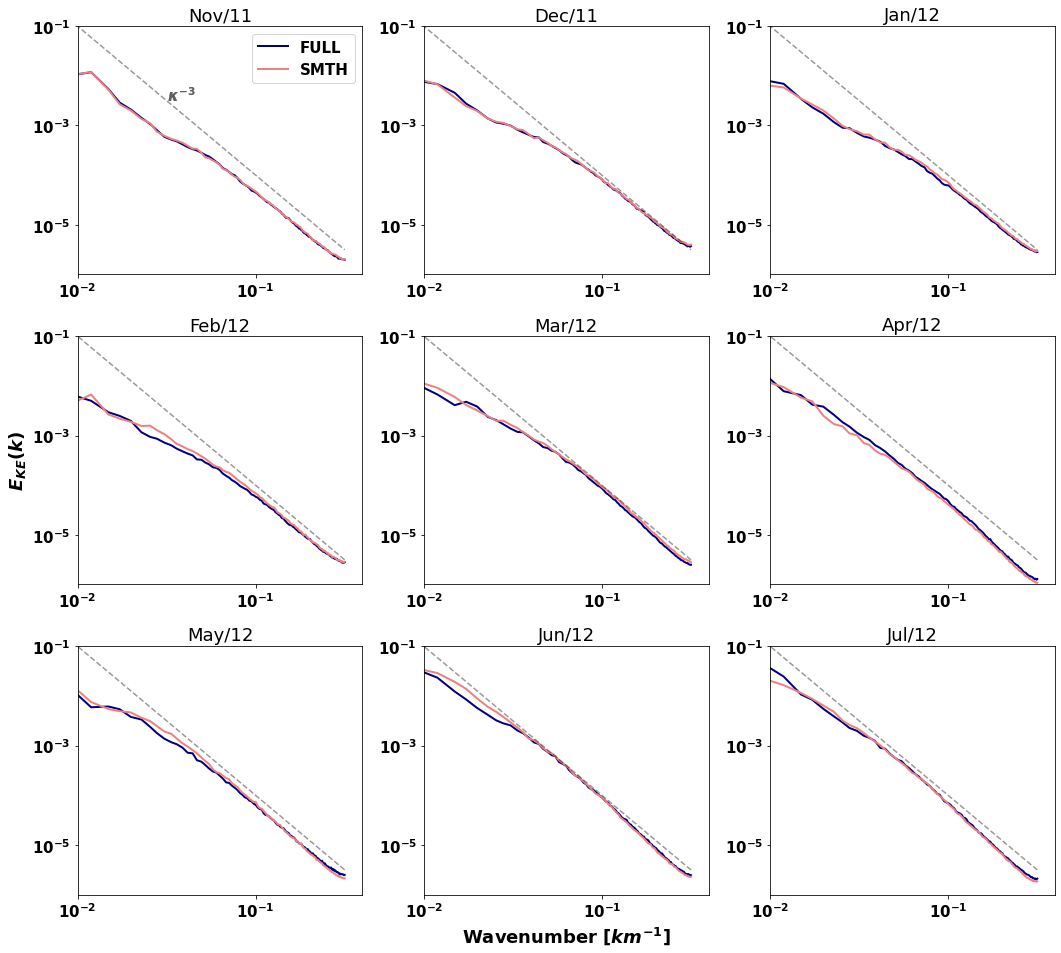

In [80]:
fig, axs = plt.subplots(3,3, figsize=(15, 13.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 1, wspace=.01)

axs = axs.ravel()

for ipp in range(len(mes)):

    axs[ipp].plot(np.log10(exspec.freq_r/dxx),np.log10(np.nanmean(Ekef[mon_ind==mes[ipp],:],axis=0)),label='FULL',linewidth=2,color='navy')
    axs[ipp].plot(np.log10(exspec.freq_r/dxx),np.log10(np.nanmean(Eket[mon_ind==mes[ipp],:],axis=0)),label='SMTH',linewidth=2,color='lightcoral')
    axs[ipp].plot(np.log10(k3),np.log10(E3),'k--',alpha=0.4)
    axs[0].text(-1.5,-2.5,r'$\kappa^{-3}$',alpha=0.1,weight='light')
    # axs[ipp].grid()
    axs[ipp].set_title(mes_str[ipp])
    axs[ipp].set_xticks(np.array([-2,-1]))
    axs[ipp].set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
    axs[ipp].set_yticks(np.array([-5,-3,-1,1,3]))
    axs[ipp].set_yticklabels([r'10$^{-5}$',r'10$^{-3}$',r'10$^{-1}$',r'10$^{1}$',r'10$^{3}$'])
    axs[7].set_xlabel(r'Wavenumber $ [km^{-1}]$',fontsize=18,fontweight='bold')
    axs[3].set_ylabel(r'$E_{KE}(k)$',color="k",fontsize=18,fontweight='bold')
    axs[0].legend()
    axs[ipp].set_xlim(-2,-0.4)
    axs[ipp].set_ylim(-6,-1)


    
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/Scripts/figures/monthly_KE.png')

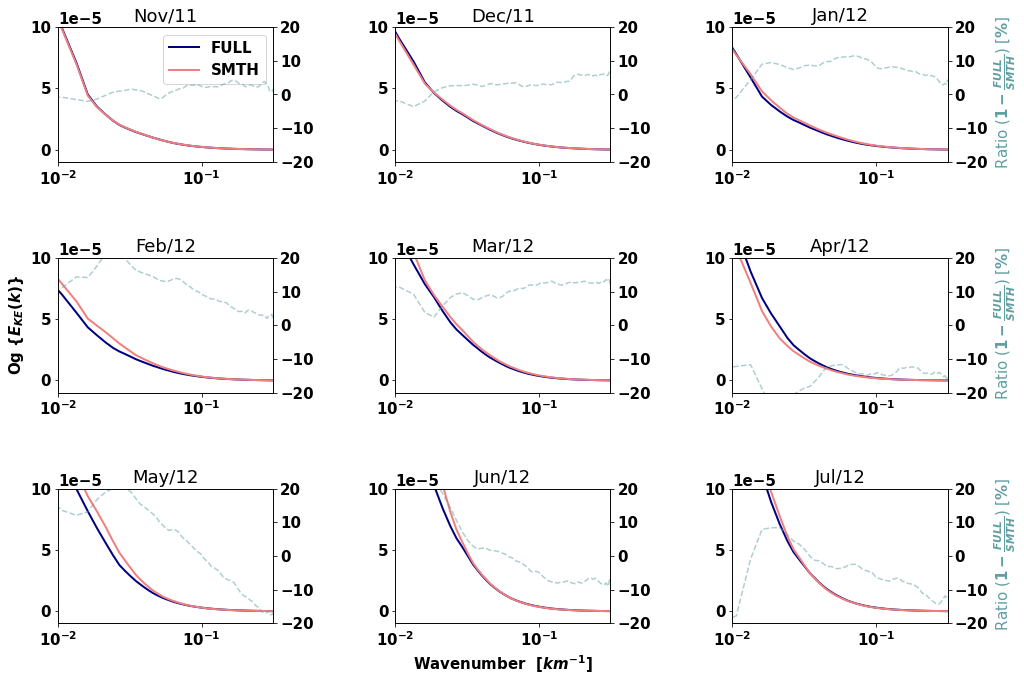

In [95]:

fig, axs = plt.subplots(3,3, figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 2, wspace=.01)

axs = axs.ravel()


for ipp in range(len(mes)):

    emf=np.nanmean(Ekef[mon_ind==mes[ipp],:],axis=0)
    emt=np.nanmean(Eket[mon_ind==mes[ipp],:],axis=0)

    Kk=np.array(exspec.freq_r/dxx)
    Kx=(Kk[:-1]+Kk[1:])/2
    dK=np.diff(Kk)[0]
    
    KEf=integ.cumtrapz(y=emf[::-1],x=Kk[::-1]);
    KEt=integ.cumtrapz(y=emt[::-1],x=Kk[::-1]);
    KEf=-KEf[::-1]
    KEt=-KEt[::-1]

    

    
    axs[ipp].plot(np.log10(Kx),KEf,label='FULL',linewidth=2,color='navy')
    axs[ipp].plot(np.log10(Kx),KEt,label='SMTH',linewidth=2,color='lightcoral')

    axs[ipp].set_title(mes_str[ipp])

    axs[7].set_xlabel(r'Wavenumber  [$km^{-1}]$',fontsize=15,fontweight='bold')
    axs[3].set_ylabel(r'Og {$E_{KE}(k)$}',color="k",fontsize=15,fontweight='bold')
    axs[0].legend()
    axs[ipp].set_xlim(-2,-0.5)
    axs[ipp].set_ylim(-1e-5,1e-4)


    axs[ipp].set_xticks(np.array([-2,-1]))
    axs[ipp].set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
    

    ax2=axs[ipp].twinx()
    ax2.plot(np.log10(Kx),(1-(KEf)/(KEt))*100,alpha=0.5,linestyle='dashed',color='cadetblue')
    if ipp in [2,5,8]:
        ax2.set_ylabel(r' Ratio ($1 - \frac{FULL}{SMTH}$) [$\%$]',fontsize=15,color='cadetblue')
    ax2.set_ylim(-20,20)
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/Scripts/figures/Ogive_monthly_KE.png')


    


## Wind KE Spectral Analysis (Whole Region)

#### Area of study cropped in attempt to exclude the effect of model's "sponge" and coastline

In [33]:
uwf=varf.U10[:,30:-30,30:200].compute()
vwf=varf.V10[:,30:-30,30:200].compute()

uwt=vart.U10[:,30:-30,30:200].compute()
vwt=vart.V10[:,30:-30,30:200].compute()

In [34]:
uwspf=xrft.isotropic_powerspectrum(uwf.drop(['nav_lat','nav_lon']),
                                   dim=['x','y'],nfactor=1,truncate='True',detrend='linear', window=True)
vwspf=xrft.isotropic_powerspectrum(vwf.drop(['nav_lat','nav_lon']),
                                   dim=['x','y'],nfactor=1,truncate='True',detrend='linear', window=True)

uwspt=xrft.isotropic_powerspectrum(uwt.drop(['nav_lat','nav_lon']),
                                   dim=['x','y'],nfactor=1,truncate='True',detrend='linear', window=True)
vwspt=xrft.isotropic_powerspectrum(vwt.drop(['nav_lat','nav_lon']),
                                   dim=['x','y'],nfactor=1,truncate='True',detrend='linear', window=True)

In [40]:
wEkef=0.5*(uwspf+vwspf)
wEket=0.5*(uwspt+vwspt)

In [12]:

# exspec=xrft.isotropic_powerspectrum(uwf[0].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)
# wEkef=np.zeros([uwf.shape[0],exspec.shape[0]])*np.nan;
# wEket=np.zeros([uwt.shape[0],exspec.shape[0]])*np.nan;

# for ixx in range(uwf.shape[0]):
#     uwspf=xrft.isotropic_powerspectrum(uwf[ixx].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)
#     vwspf=xrft.isotropic_powerspectrum(vwf[ixx].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)
#     uwspt=xrft.isotropic_powerspectrum(uwt[ixx].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)
#     vwspt=xrft.isotropic_powerspectrum(vwt[ixx].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)


#     wEkef[ixx,:]=(uwspf.to_numpy()+ vwspf.to_numpy())/2
#     wEket[ixx,:]=(uwspt.to_numpy() + vwspt.to_numpy())/2

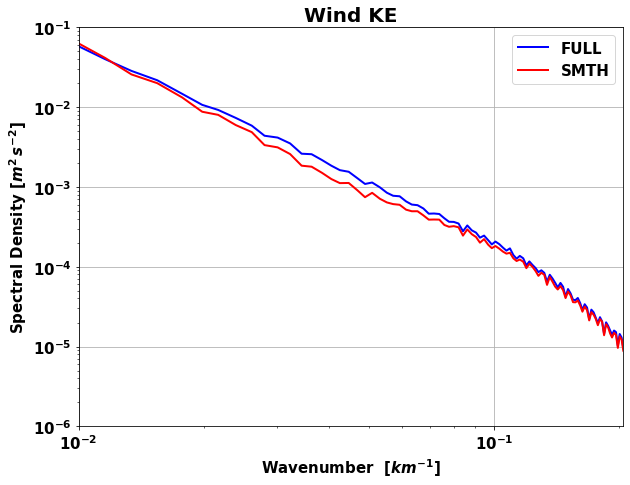

In [89]:
dxx=2
plt.figure(figsize=(9,7))


plt.plot(wEkef.freq_r/dxx,
        np.nanmean(wEkef,axis=0),label='FULL',linewidth=2,color='blue')


plt.plot(exspec.freq_r/dxx,
        np.nanmean(wEket,axis=0),label='SMTH',linewidth=2,color='red')
# plt.plot(np.log10(iso_eket[0]),
#          np.log10((iso_eket[0]/iso_eket[1]**-2)[::-1]),color='green')

# plt.plot(np.log10(k3*1.2),np.log10(E3*1.2),'k--')


plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid()

# plt.xticks(np.array([-2,-1]),[r'10$^{-2}$',r'10$^{-1}$'])
# plt.yticks(np.array([-5,-3,-1,1,3]),[r'10$^{-5}$',r'10$^{-3}$',r'10$^{-1}$',r'10$^{1}$',r'10$^{3}$'])
# plt.xticks(([1/300,1/150,1/100,1/50,1/40,1/10,1/5]),[300,150,100,50,40,10,5])

#plt.title(np.datetime_as_string(varf.time_counter[xday].data)[:10])
plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold',fontsize=15)
# plt.xlabel(r'Wavelength  $[km]$',fontweight='bold',fontsize=15)



plt.ylabel(r'Spectral Density [$m^2\,s^{-2}$]',fontweight='bold',fontsize=15)
plt.title(r'Wind KE',fontweight='bold',fontsize=20)

plt.xlim(1e-2,10**-0.69)
plt.ylim(1e-6,1e-1)
plt.tight_layout()

plt.savefig('/homes/metogra/iufarias/Documents/figures/1_WRF/spectral/Total_avg_wind_KE_wavenumber.png')






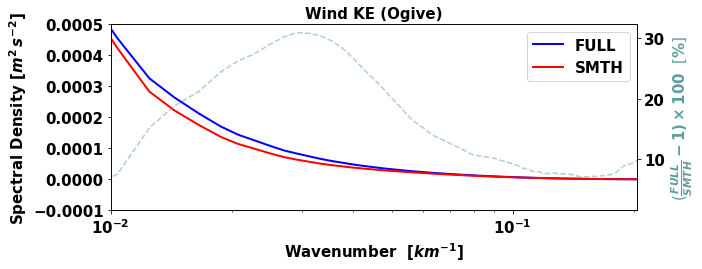

In [114]:
# Wef=np.nanmean(wEkef,axis=0)
# Wet=np.nanmean(wEket,axis=0)
Wef=wEkef.mean(axis=0)
Wet=wEket.mean(axis=0)


Kk=np.array(Wef.freq_r/dxx)
Kx=(Kk[:-1]+Kk[1:])/2
dK=np.diff(Kk)[0]


WKf=integ.cumtrapz(y=Wef[::-1],x=Kk[::-1]);
WKt=integ.cumtrapz(y=Wet[::-1],x=Kk[::-1]);

WKf=-WKf[::-1]
WKt=-WKt[::-1]

fig,ax = plt.subplots(figsize=(10,4))
ax.plot(Kx,WKf,label='FULL',linewidth=2,color='blue')
ax.plot(Kx,WKt,label='SMTH',linewidth=2,color='red')
ax.set_xlabel(r'Wavenumber  $[km^{-1}]$',fontsize=15,fontweight='bold')
ax.set_ylabel(r'Spectral Density [$m^2\,s^{-2}$]',fontweight='bold',fontsize=15)
ax.set_xticks(np.array([-2,-1]))
ax.set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
ax.set_xscale('log')
ax.set_xlim(1e-2,10**-0.69)
ax.set_ylim(-1e-4,5e-4)
ax.set_title('Wind KE (Ogive)',fontsize=15,fontweight='bold')

ax.legend()

ax2=ax.twinx()
# ax2.plot(Kx,(1-(WKf)/(WKt))*100,alpha=0.5,linestyle='dashed',color='cadetblue')
# ax2.set_ylabel(r' Ratio ($1 - \frac{FULL}{SMTH}$) [$\%$]',fontsize=15,color='cadetblue')
# ax2.set_xscale('log')

ax2.plot(Kx,((WKf)/(WKt)-1)*100,alpha=0.5,linestyle='dashed',color='cadetblue')
ax2.set_ylabel(r'($\frac{FULL}{SMTH}-1)\times 100$  [$\%$]',fontsize=15,color='cadetblue')
ax2.set_xscale('log')


plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/1_WRF/spectral/Ogive_total_avg_wind_KE.png')



NameError: name 'mes' is not defined

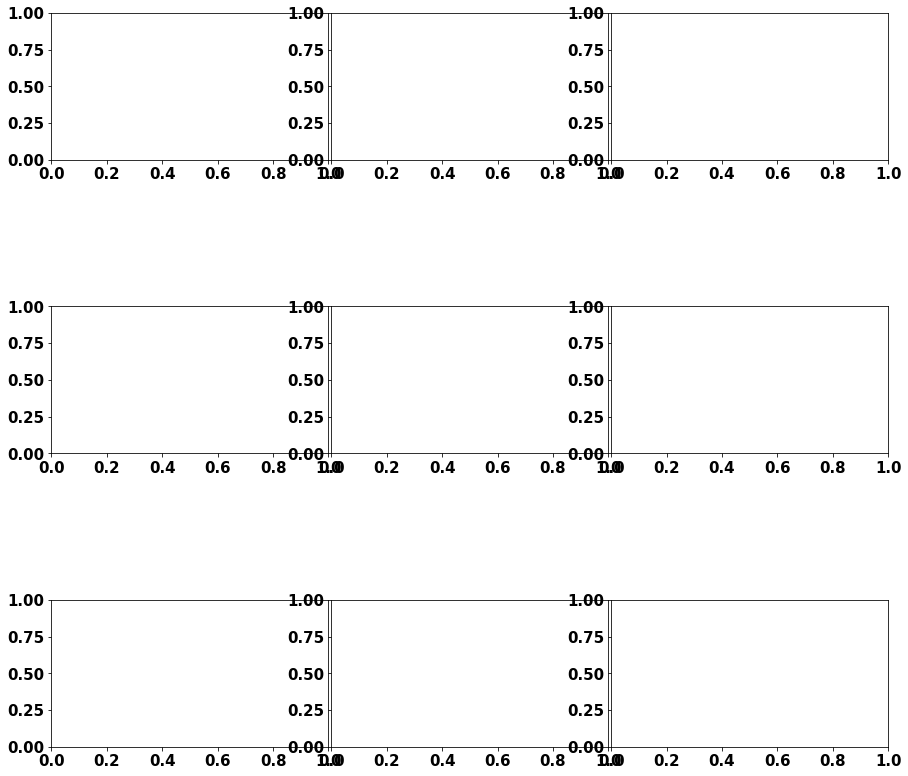

In [102]:

fig, axs = plt.subplots(3,3, figsize=(15, 13.5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 1, wspace=.01)

axs = axs.ravel()

for ipp in range(len(mes)):

    axs[ipp].plot(np.log10(exspec.freq_r/dxx),np.log10(np.nanmean(wEkef[mon_ind==mes[ipp],:],axis=0)),label='FULL',linewidth=2,color='blue')
    axs[ipp].plot(np.log10(exspec.freq_r/dxx),np.log10(np.nanmean(wEket[mon_ind==mes[ipp],:],axis=0)),label='SMTH',linewidth=2,color='red')
    # axs[ipp].grid()
    axs[ipp].set_title(mes_str[ipp])
    axs[ipp].set_xticks(np.array([-2,-1]))
    axs[ipp].set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
    axs[ipp].set_yticks(np.array([-5,-2,0,2,4]))
    axs[ipp].set_yticklabels([r'10$^{-5}$',r'10$^{-2}$',r'10$^{0}$',r'10$^{2}$',r'10$^{4}$'])
    axs[3].set_ylabel(r'$E_{Wind\,KE}(k)$',fontsize=18,fontweight='bold')
    axs[7].set_xlabel(r'Wavenumber  $[km^{-1}]$',fontsize=18,fontweight='bold')


    axs[ipp].set_xlim(-2,-0.4)
    axs[ipp].set_ylim(-6,0)


    axs[0].legend()
    
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/Scripts/figures/monthly_Wind_KE.png')




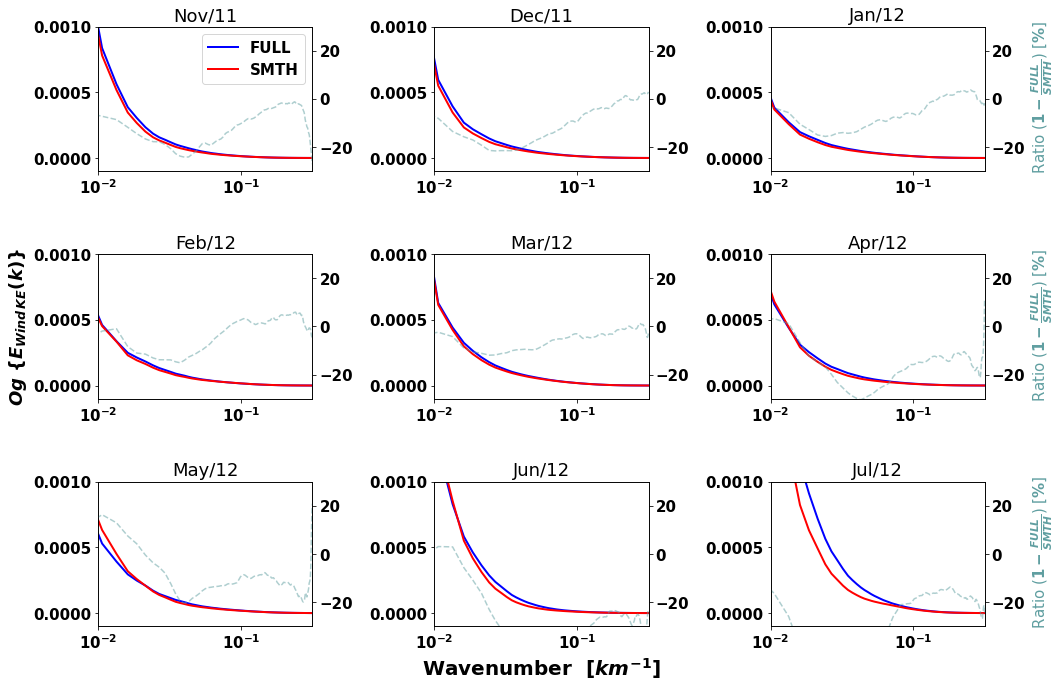

In [125]:

fig, axs = plt.subplots(3,3, figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 1.5, wspace=.01)

axs = axs.ravel()


for ipp in range(len(mes)):

    wemf=np.nanmean(wEkef[mon_ind==mes[ipp],:],axis=0)
    wemt=np.nanmean(wEket[mon_ind==mes[ipp],:],axis=0)

    Kk=np.array(exspec.freq_r/dxx)
    Kx=(Kk[:-1]+Kk[1:])/2
    dK=np.diff(Kk)[0]
    
    wKEf=integ.cumtrapz(y=wemf[::-1],x=Kk[::-1]);
    wKEt=integ.cumtrapz(y=wemt[::-1],x=Kk[::-1]);
    wKEf=-wKEf[::-1]
    wKEt=-wKEt[::-1]

    

    
    axs[ipp].plot(np.log10(Kx),(wKEf),label='FULL',linewidth=2,color='blue')
    axs[ipp].plot(np.log10(Kx),(wKEt),label='SMTH',linewidth=2,color='red')

    axs[ipp].set_title(mes_str[ipp])

    axs[7].set_xlabel(r'Wavenumber  $[km^{-1}]$',fontsize=20,fontweight='bold')
    axs[3].set_ylabel(r'$Og$ {$E_{Wind\,KE}(k)$}',color="k",fontsize=18,fontweight='bold')
    axs[0].legend()

    axs[ipp].set_xticks(np.array([-2,-1]))
    axs[ipp].set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])

    axs[ipp].set_xlim(-2,-0.5)
    axs[ipp].set_ylim(-1e-4,1e-3)
    
    ax2=axs[ipp].twinx()
    ax2.plot(np.log10(Kx),(1-((wKEf)/(wKEt)))*100,alpha=0.5,linestyle='dashed',color='cadetblue')
    if ipp in [2,5,8]:
        ax2.set_ylabel(r' Ratio ($1 - \frac{FULL}{SMTH}$) [$\%$]',fontsize=15,color='cadetblue')
    ax2.set_ylim(-30,30)





plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/Scripts/figures/Ogive_monthly_Wind_KE.png')




## Wind Work Espectral Analysis (Whole Region)



In [10]:
# uf=varf.UOCE[:,30:-30,30:200] 
# vf=varf.VOCE[:,30:-30,30:200]
# uwf=varf.U10[:,30:-30,30:200] 
# vwf=varf.V10[:,30:-30,30:200] 
# wf=varf.WSPD10[:,30:-30,30:200] 


# ut=vart.UOCE[:,30:-30,30:200]
# vt=vart.VOCE[:,30:-30,30:200]
# uwt=vart.U10[:,30:-30,30:200] 
# vwt=vart.V10[:,30:-30,30:200] 
# wt=vart.WSPD10[:,30:-30,30:200]

In [13]:
#stress
# tx_f= 1.25*10e-3*(wf)*(uwf)
# ty_f= 1.25*10e-3*(wf)*(vwf)

# tx_t=1.25*10e-3*(wt)*(uwt)
# ty_t=1.25*10e-3*(wt)*(vwt)

tx_f= 1.25*10e-3*(wf-np.sqrt(uf**2 + vf**2))*(uwf - uf)
ty_f= 1.25*10e-3*(wf-np.sqrt(ut**2 + vf**2))*(vwf - vf)

tx_t=1.25*10e-3*(wt-np.sqrt(ut**2 + vt**2))*(uwt - ut)
ty_t=1.25*10e-3*(wt-np.sqrt(ut**2 + vt**2))*(vwt - vt)

In [14]:
exspec=xrft.isotropic_cross_spectrum(uf[0].drop(['nav_lat','nav_lon']),uf[0].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)
WWf=np.zeros([uf.shape[0],exspec.shape[0]])*np.nan;
WWt=np.zeros([ut.shape[0],exspec.shape[0]])*np.nan;

# xrft.isotropic_cross_spectrum

# xrft.
for ixx in range(uf.shape[0]):
    'Full'
    Xf_hat=xrft.isotropic_cross_spectrum(tx_f[ixx].drop(['nav_lat','nav_lon']),uf[ixx].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)
    Yf_hat=xrft.isotropic_cross_spectrum(ty_f[ixx].drop(['nav_lat','nav_lon']),vf[ixx].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)
    Xf_hat=Xf_hat.real
    Yf_hat=Yf_hat.real
    
    'Smth'
    Xt_hat=xrft.isotropic_cross_spectrum(tx_t[ixx].drop(['nav_lat','nav_lon']),ut[ixx].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)
    Yt_hat=xrft.isotropic_cross_spectrum(ty_t[ixx].drop(['nav_lat','nav_lon']),vt[ixx].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)
    Xt_hat=Xt_hat.real
    Yt_hat=Yt_hat.real

    WWf[ixx,:]=(Xf_hat.to_numpy() + Yf_hat.to_numpy())*(1/1024)
    WWt[ixx,:]=(Xt_hat.to_numpy() + Yt_hat.to_numpy())*(1/1024)




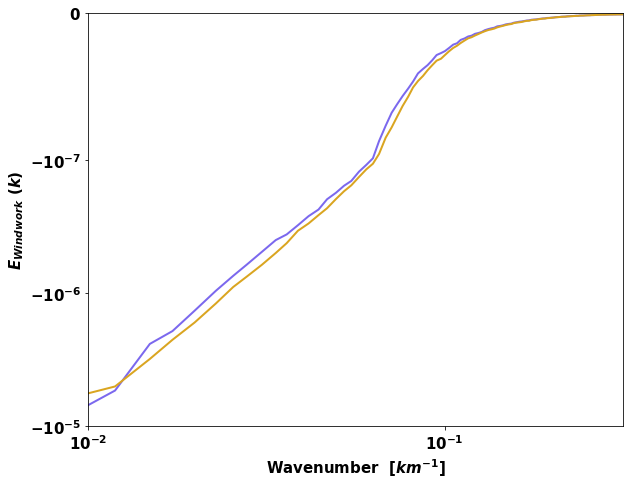

In [16]:
plt.figure(figsize=(9,7))


# plt.plot(np.log10(exspec.freq_r/dxx),np.log10(-np.nanmean(WWf,axis=0)),label='FULL',linewidth=2,color='mediumslateblue')
# plt.plot(np.log10(exspec.freq_r/dxx),np.log10(-np.nanmean(WWt,axis=0)),label='SMTH',linewidth=2,color='goldenrod')


plt.plot((exspec.freq_r/dxx),(np.nanmean(WWf,axis=0)),label='FULL',linewidth=2,color='mediumslateblue')
plt.plot((exspec.freq_r/dxx),(np.nanmean(WWt,axis=0)),label='SMTH',linewidth=2,color='goldenrod')







# plt.grid()
# plt.xticks(np.array([-5,-4]),[r'10$^{-5}$',r'10$^{-4}$'])
# plt.yticks(np.array([-5,-7,-9]),[r'-10$^{-5}$',r'-10$^{-7}$',r'-10$^{-9}$'])

plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'$E_{Windwork}\,\,(k)$')
plt.xlim(10**(-2),10**(-0.5))
plt.ylim(-10**(-5),0)
plt.yscale('symlog',linthreshy=1e-7)
plt.xscale('symlog',linthreshx=1e-2)

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/Scripts/figures/Total_avg_Windwork_KE.png')



findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


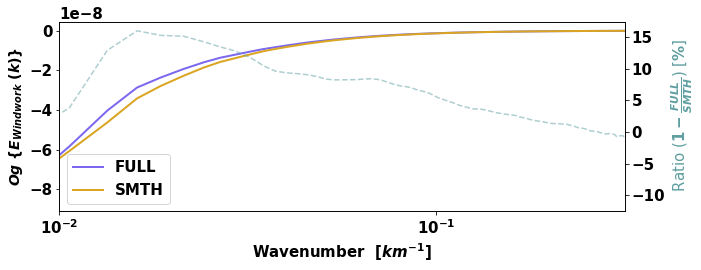

In [17]:
wwf=np.nanmean(WWf,axis=0)
wwt=np.nanmean(WWt,axis=0)

Kk=np.array(exspec.freq_r/dxx)
Kx=(Kk[:-1]+Kk[1:])/2
dK=np.diff(Kk)[0]


WWpf=integ.cumtrapz(y=wwf[::-1],x=Kk[::-1]);
WWpt=integ.cumtrapz(y=wwt[::-1],x=Kk[::-1]);
WWpf=-WWpf[::-1]
WWpt=-WWpt[::-1]



fig,ax = plt.subplots(figsize=(10,4))
ax.plot(np.log10(Kx),WWpf,label='FULL',linewidth=2,color='mediumslateblue')
ax.plot(np.log10(Kx),WWpt,label='SMTH',linewidth=2,color='goldenrod')
ax.set_xlabel(r'Wavenumber  $[km^{-1}]$',fontsize=15,fontweight='bold')
ax.set_ylabel(r'$Og$ {$E_{Windwork}\,\,(k)$}',color="k",fontsize=14,fontweight='bold')

ax.set_xticks(np.array([-2,-1]))
ax.set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
# ax.set_ylim(0,6e-11)
ax.set_xlim(-2,-0.5)
ax.legend()

ax2=ax.twinx()
ax2.plot(np.log10(Kx),(1-((WWpf)/(WWpt)))*100,alpha=0.5,linestyle='dashed',color='cadetblue')
ax2.set_ylabel(r' Ratio ($1 - \frac{FULL}{SMTH}$) [$\%$]',fontsize=15,color='cadetblue')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/Scripts/figures/Ogive_total_windwork.png')



findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


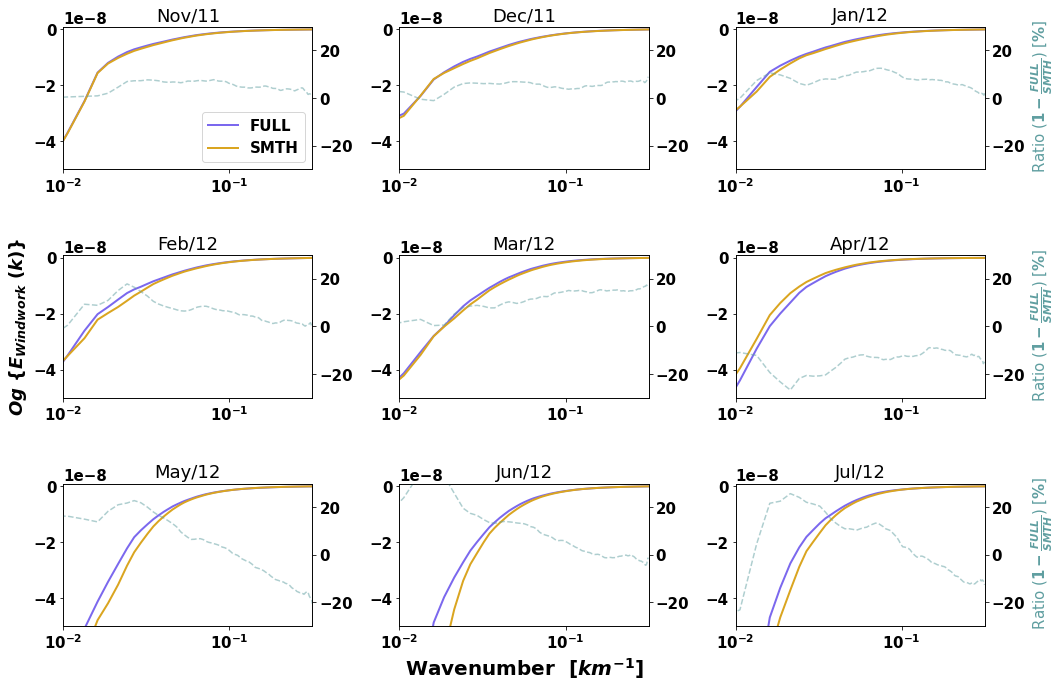

In [19]:

fig, axs = plt.subplots(3,3, figsize=(15, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 1.5, wspace=.01)

axs = axs.ravel()


for ipp in range(len(mes)):

    fkmf=np.nanmean(WWf[mon_ind==mes[ipp],:],axis=0)
    fkmt=np.nanmean(WWt[mon_ind==mes[ipp],:],axis=0)

    Kk=np.array(exspec.freq_r/dxx)
    Kx=(Kk[:-1]+Kk[1:])/2
    dK=np.diff(Kk)[0]
    
    FKf=integ.cumtrapz(y=fkmf[::-1],x=Kk[::-1]);
    FKt=integ.cumtrapz(y=fkmt[::-1],x=Kk[::-1]);
    FKf=-FKf[::-1]
    FKt=-FKt[::-1]

    

    
    axs[ipp].plot(np.log10(Kx),(FKf),label='FULL',linewidth=2,color='mediumslateblue')
    axs[ipp].plot(np.log10(Kx),(FKt),label='SMTH',linewidth=2,color='goldenrod')

    axs[ipp].set_title(mes_str[ipp])

    axs[7].set_xlabel(r'Wavenumber  $[km^{-1}]$',fontsize=20,fontweight='bold')
    axs[3].set_ylabel(r'$Og$ {$E_{Windwork}\,\,(k)$}',color="k",fontsize=18,fontweight='bold')
    axs[0].legend()

    axs[ipp].set_xticks(np.array([-2,-1]))
    axs[ipp].set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])

    axs[ipp].set_xlim(-2,-0.5)
    axs[ipp].set_ylim(-5e-8,1e-9)
    
    ax2=axs[ipp].twinx()
    ax2.plot(np.log10(Kx),(1-((FKf)/(FKt)))*100,alpha=0.5,linestyle='dashed',color='cadetblue')
    if ipp in [2,5,8]:
        ax2.set_ylabel(r' Ratio ($1 - \frac{FULL}{SMTH}$) [$\%$]',fontsize=15,color='cadetblue')
    ax2.set_ylim(-30,30)

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/Scripts/figures/Ogive_monthly_WindWork.png')




## Two Sections

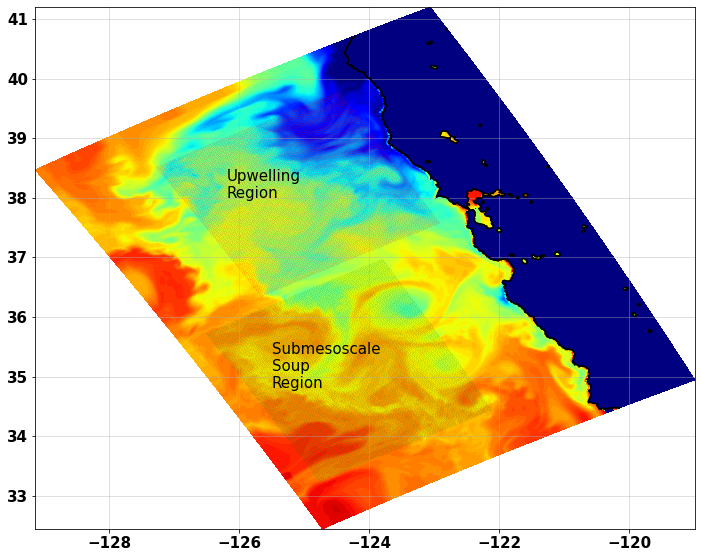

In [247]:
xx=np.arange(varf.SST[0,0,:].shape[0])
yy=np.arange(varf.SST[0,:,0].shape[0])


xm1=np.arange(70,210)
ym1=np.arange(210,350)

xm2=np.arange(20,160)
ym2=np.arange(40,200)

xx1,yy1=np.meshgrid(xx,yy)

plt.figure(figsize=(10,8))
plt.contourf(varf.nav_lon,varf.nav_lat,varf.SST[0,:,:],levels=np.linspace(283,290,65),cmap='jet',extend='both')
plt.contour(varf.nav_lon,varf.nav_lat,varf.SST[0,:,:],levels=[0,1e-15],colors='black')


plt.scatter(varf.nav_lon[ym1,:][:,xm1],varf.nav_lat[ym1,:][:,xm1],s=0.01,alpha=0.5,c='r',label='Upwelling')
plt.scatter(varf.nav_lon[ym2,:][:,xm2],varf.nav_lat[ym2,:][:,xm2],s=0.01,alpha=0.5,c='g',label='Soup')
plt.text(-126.2,38,'Upwelling\nRegion',fontweight='normal')
plt.text(-125.5,34.8,'Submesoscale\nSoup\nRegion',fontweight='normal')


plt.grid(alpha=0.5)
# plt.legend()
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/Scripts/figures/map_2regions.png')



In [248]:
'Upwelling Region'
usf1=varf.UOCE[:,ym1,xm1]
vsf1=varf.VOCE[:,ym1,xm1]

ust1=vart.UOCE[:,ym1,xm1]
vst1=vart.VOCE[:,ym1,xm1]

'Soup Region'
usf2=varf.UOCE[:,ym2,xm2]
vsf2=varf.VOCE[:,ym2,xm2]

ust2=vart.UOCE[:,ym2,xm2]
vst2=vart.VOCE[:,ym2,xm2]

In [250]:
exspec1=xrft.isotropic_powerspectrum(usf1[0].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)
Eke1f=np.zeros([usf1.shape[0],exspec1.shape[0]])*np.nan;
Eke1t=np.zeros([ust1.shape[0],exspec1.shape[0]])*np.nan;

for ixx in range(usf1.shape[0]):
    upf1=xrft.isotropic_powerspectrum(usf1[ixx].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)
    vpf1=xrft.isotropic_powerspectrum(vsf1[ixx].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)
    upt1=xrft.isotropic_powerspectrum(ust1[ixx].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)
    vpt1=xrft.isotropic_powerspectrum(vst1[ixx].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)


    Eke1f[ixx,:]=(upf1.to_numpy()+ vpf1.to_numpy())/2
    Eke1t[ixx,:]=(upt1.to_numpy() + vpt1.to_numpy())/2

    

exspec2=xrft.isotropic_powerspectrum(usf2[0].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)
Eke2f=np.zeros([usf2.shape[0],exspec2.shape[0]])*np.nan;
Eke2t=np.zeros([ust2.shape[0],exspec2.shape[0]])*np.nan;

for ixx in range(usf2.shape[0]):
    upf2=xrft.isotropic_powerspectrum(usf2[ixx].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)
    vpf2=xrft.isotropic_powerspectrum(vsf2[ixx].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)
    upt2=xrft.isotropic_powerspectrum(ust2[ixx].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)
    vpt2=xrft.isotropic_powerspectrum(vst2[ixx].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)


    Eke2f[ixx,:]=(upf2.to_numpy()+ vpf2.to_numpy())/2
    Eke2t[ixx,:]=(upt2.to_numpy() + vpt2.to_numpy())/2

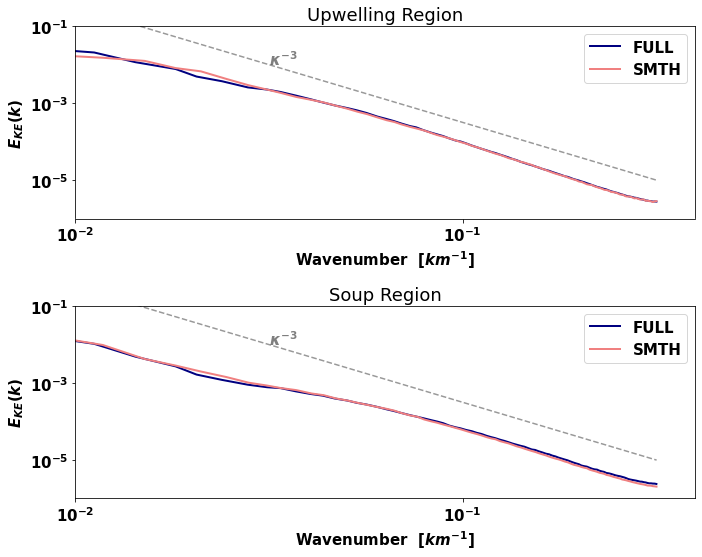

In [257]:
k2 = np.array([exspec.freq_r[0],exspec.freq_r[-1]])/dxx
E2 = 1/k2**2/(10**6.8)
k3 = np.array([exspec.freq_r[0],exspec.freq_r[-1]])/dxx
E3 = 1/k3**3/(10**6.5)

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)

plt.plot(np.log10(exspec1.freq_r/dxx),
        np.log10(np.nanmean(Eke1f,axis=0)),label='FULL',linewidth=2,color='navy')


plt.plot(np.log10(exspec2.freq_r/dxx),
        np.log10(np.nanmean(Eke1t,axis=0)),label='SMTH',linewidth=2,color='lightcoral')

plt.plot(np.log10(k3),np.log10(E3),'k--',alpha=0.4)
plt.text(-1.5,-2,r'$\kappa^{-3}$',weight='normal',alpha=0.5)

plt.legend()
plt.title('Upwelling Region')
plt.xticks(np.array([-2,-1]),[r'10$^{-2}$',r'10$^{-1}$'])
plt.yticks(np.array([-5,-3,-1,1,3]),[r'10$^{-5}$',r'10$^{-3}$',r'10$^{-1}$',r'10$^{1}$',r'10$^{3}$'])
plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'$E_{KE}(k)$',fontweight='bold')
plt.xlim(-2,-0.4)
plt.ylim(-6,-1)



plt.subplot(2,1,2)

plt.plot(np.log10(exspec1.freq_r/dxx),
        np.log10(np.nanmean(Eke2f,axis=0)),label='FULL',linewidth=2,color='navy')


plt.plot(np.log10(exspec2.freq_r/dxx),
        np.log10(np.nanmean(Eke2t,axis=0)),label='SMTH',linewidth=2,color='lightcoral')

plt.plot(np.log10(k3),np.log10(E3),'k--',alpha=0.4)
plt.text(-1.5,-2,r'$\kappa^{-3}$',weight='normal',alpha=0.5)

plt.legend()
plt.title('Soup Region')

plt.xticks(np.array([-2,-1]),[r'10$^{-2}$',r'10$^{-1}$'])
plt.yticks(np.array([-5,-3,-1,1,3]),[r'10$^{-5}$',r'10$^{-3}$',r'10$^{-1}$',r'10$^{1}$',r'10$^{3}$'])

plt.xlabel(r'Wavenumber  $[km^{-1}]$',fontweight='bold')
plt.ylabel(r'$E_{KE}(k)$',fontweight='bold')
plt.xlim(-2,-0.4)
plt.ylim(-6,-1)
plt.tight_layout()

plt.savefig('/homes/metogra/iufarias/Documents/Scripts/figures/2region_avg_KE.png')



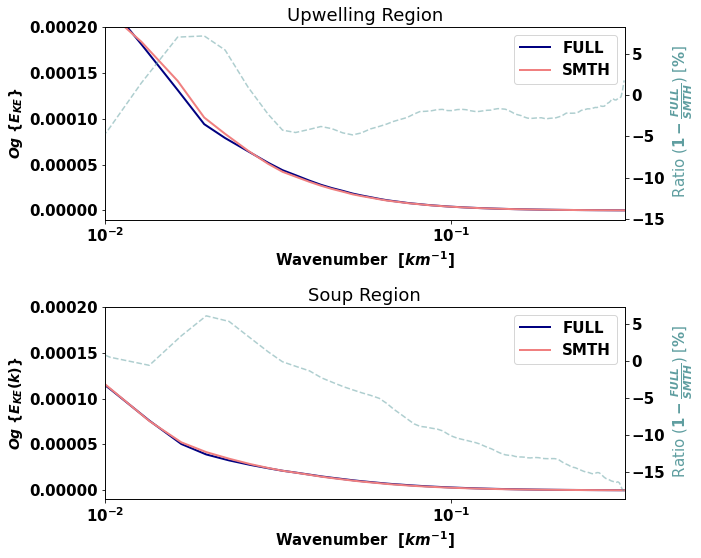

In [ ]:
exspec1=xrft.isotropic_powerspectrum(usf1[0].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)


EKE1f=np.nanmean(Eke1f,axis=0)
EKE1t=np.nanmean(Eke1t,axis=0)

Kk1=np.array(exspec1.freq_r/dxx)
Kx1=(Kk1[:-1]+Kk1[1:])/2
dK1=np.diff(Kk1)[0]


EKf1=integ.cumtrapz(y=EKE1f[::-1],x=Kk1[::-1]);
EKt1=integ.cumtrapz(y=EKE1t[::-1],x=Kk1[::-1]);
EKf1=-EKf1[::-1]
EKt1=-EKt1[::-1]

fig,ax = plt.subplots(ncols=1,nrows=2,figsize=(10,8))
ax=ax.ravel()
ax[0].plot(np.log10(Kx1),(EKf1),label='FULL',linewidth=2,color='navy')
ax[0].plot(np.log10(Kx1),(EKt1),label='SMTH',linewidth=2,color='lightcoral')
ax[0].set_xlabel(r'Wavenumber  $[km^{-1}]$',fontsize=15,fontweight='bold')
ax[0].set_ylabel(r'$Og$ {$E_{KE}$}',color="k",fontsize=14,fontweight='bold')
ax[0].set_title('Upwelling Region')
ax[0].set_xticks(np.array([-2,-1]))
ax[0].set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
ax[0].set_ylim(-1e-5,2e-4)

ax[0].set_xlim(-2,-0.5)
ax[0].legend()

ax2=ax[0].twinx()
ax2.plot(np.log10(Kx1),(1-((EKf1)/(EKt1)))*100,alpha=0.5,linestyle='dashed',color='cadetblue')
ax2.set_ylabel(r' Ratio ($1 - \frac{FULL}{SMTH}$) [$\%$]',fontsize=15,color='cadetblue')




exspec2=xrft.isotropic_powerspectrum(usf2[0].drop(['nav_lat','nav_lon']),nfactor=1,truncate='True',detrend='linear', window=True)


EKE2f=np.nanmean(Eke2f,axis=0)
EKE2t=np.nanmean(Eke2t,axis=0)

Kk2=np.array(exspec2.freq_r/dxx)
Kx2=(Kk2[:-1]+Kk2[1:])/2
dK2=np.diff(Kk2)[0]


EKf2=integ.cumtrapz(y=EKE2f[::-1],x=Kk2[::-1]);
EKt2=integ.cumtrapz(y=EKE2t[::-1],x=Kk2[::-1]);
EKf2=-EKf2[::-1]
EKt2=-EKt2[::-1]

ax[1].plot(np.log10(Kx2),(EKf2),label='FULL',linewidth=2,color='navy')
ax[1].plot(np.log10(Kx2),(EKt2),label='SMTH',linewidth=2,color='lightcoral')
ax[1].set_xlabel(r'Wavenumber  $[km^{-1}]$',fontsize=15,fontweight='bold')
ax[1].set_ylabel(r'$Og$ {$E_{KE}(k)$}',color="k",fontsize=14,fontweight='bold')
ax[1].set_title('Soup Region')
ax[1].set_xticks(np.array([-2,-1]))
ax[1].set_xticklabels([r'10$^{-2}$',r'10$^{-1}$'])
ax[1].set_ylim(-1e-5,2e-4)
ax[1].set_xlim(-2,-0.5)
ax[1].legend()

ax2=ax[1].twinx()
ax2.plot(np.log10(Kx2),(1-((EKf2)/(EKt2)))*100,alpha=0.5,linestyle='dashed',color='cadetblue')
ax2.set_ylabel(r' Ratio ($1 - \frac{FULL}{SMTH}$) [$\%$]',fontsize=15,color='cadetblue')
plt.tight_layout()


plt.tight_layout()






plt.savefig('/homes/metogra/iufarias/Documents/Scripts/figures/Ogive_2region_avg_KE.png')


